In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [2]:
def gera_matriz(num_matriz, n):
    """ 
    Retorna as matrizes que serão utilizadas pelo algoritmo
    
    Parameters
    -------------
    num_matriz : int
        Um inteiro (1 ou 2), que representa qual o formato da matriz que deve ser retornada
    
    n : int
        Um inteiro que é a dimensão da matriz que deve ser retornada
    
    Returns
    -------------
    A : np.array
        Caso num_matriz seja 1, retorna um np.array de dimensão nxn que 
        representa a matriz que será utilizada na simulação,
        caso num_matriz seja 2, retornará as duas matrizes de dimensões nxn
        que serão utilizadas na simulação.
    """
    
    B0 = np.random.random_sample((n,n))
    A = np.zeros((n, n))
    I = np.identity(n)
    if num_matriz == 1:
        A = B0+B0.T+n*I
        return A
        
    else:
        p=3*n
        B = B0+p*I 
        autovalores_1 = [10.71, 12.64, 14.86,  8.07, 11.29,  4.05, 10.12, 3.51,  6.35, 13.02] #autovalores próximos
        autovalores_2 = [ 3.53,  9.26, 18.75, 13.88,  6.41, 10.77, 12.31, 9.78, 11.35, 10.92] # autovalores distantes
        D_1 = np.diag(np.array(autovalores_1)[:n])
        D_2 = np.diag(np.array(autovalores_2)[:n])
        B_inv = np.linalg.inv(B)
        A_1 = B @ D_1 @ B_inv
        A_2 = B @ D_2 @ B_inv
        return A_1, A_2

In [3]:
class MetodoDasPotenciasInverso:
    """
    Uma classe usada para representar o método das potências inverso,
    que é utilizado para calcular o maior autovetor e autovalor
    da matriz inversa de A  
    
    ...
    Attributes
    ------------
    x : list
        uma lista contendo todos os valores assumidos 
        por x durante a execução do algoritmo
        
    mi : list
        uma lista contendo todos os valores assumidos 
        por mi durante a execução do algoritmo
        
    A : np.array
        a matriz sobre a qual sera aplicada o método
        das potências inverso
    
    n : int
        um inteiro que representa a dimensão da matriz 
        quadrada A
        
    it_max : int
        número de iterações máximas do algoritmo
        
    eps: float
        diferença entre o valor obtido e o valor tabelado
        a partir da qual pode-se parar a simulação
        
    erro_autovalor : list
        lista que armazena o erro entre o autovalor 
        calculado e o tabelado
        
    erro_autovetor : list
        lista que armazena o erro entre o autovetor
        calculado e o tabelado
        
    lambda_1 : float
        maior autovalor da matriz A calculado utilizando
        a biblioteca np.linalg.eig, que serve como valor 
        tabelado para calcular o erro
        
    x_estrela : np.array
        autovetor associado ao lambda_1, calculado utilizando
        a biblioteca np.linalg.eig, que serve como o
        autovetor tabelado para calcular o erro
        
    
    Methods
    -----------
    _calcula_mi()
        Calcula o mi de acordo com o método das potências inverso
        
    _calcula_x()
        Calcula o x de acordo com o método das potências inverso
        
    _calcula_erros()
        Calcula os erros do autovetor e do autovalor
        utilizando os valores calculados
        
    _criterio_das_linhas()
        Verifica se a matriz A satisfaz o critério das linhas
    
    _sor()
        Executa o método SOR para a determinação das soluções do sistema linear
        
    calcula_aproximacao()
        Executa as iterações até chegar em uma solução 
        para o autovetor que convirja para a solução
        tabelada
        
    gera_grafico_comparativo(titulo, savefig=False, filename="")
        Função que gera o gráfico comparativo para as ordens de
        convergência.
        
    """
    def __init__(self, A, omega, it_max, eps):
        self.x_nao_normalizado = []
        self.x = []
        self.mi = []
        self.n = A.shape[0]
        self.A = A
        self.omega = omega
        self.it_max = it_max
        self.eps = eps
        
        
        #obtem os autovalores e autovetores de A inversa
        autovalores, autovetores = np.linalg.eig(np.linalg.inv(A))
        
        #salva os indices dos dois maiores autovalores
        A_argsort = np.argsort(np.abs(autovalores), axis=0)
        id_max_1 = A_argsort[-1]
        id_max_2 = A_argsort[-2]
        
        #pega os valores dos dois maiores autovetores
        lambda_1 = autovalores[id_max_1]
        lambda_2 = autovalores[id_max_2]
        
        #pega o autovetor correspondente ao maior autovalor
        x_estrela = autovetores.T[id_max_1]
        
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.eta = abs(lambda_2/lambda_1)
        self.x_estrela = x_estrela
        
        self.erro_autovetor = []
        self.erro_autovalor = []
        return
    
    def _calcula_mi(self):
        """
        Calcula o mi de acordo com o método das potências inverso
        """
        x_k = self.x[-1]
        x_k_nao_normalizado = self.x_nao_normalizado[-1]
        mi_k = (x_k.T @ x_k_nao_normalizado)/(x_k.T @ x_k)
        self.mi.append(mi_k)
        return
    
    def _calcula_x(self):
        """
        Calcula o x de acordo com o método das potências inverso
        """
        x_k = self.x[-1]
        x_k_nn_prox = self._sor()
        self.x_nao_normalizado.append(x_k_nn_prox)
        x_k_prox = x_k_nn_prox/(np.linalg.norm(x_k_nn_prox))
        self.x.append(x_k_prox)
        return
    
    def _criterio_das_linhas(self):
        """
        Verifica se a matriz A satisfaz o critério das linhas
        """
        for i in range(self.n):
            if self.A[i].sum()-self.A[i][i]>self.A[i][i]:
                return False
            
        return True
    
    def _sor(self):
        """
        Executa o método SOR para a determinação das soluções do sistema linear
        """
        satisfaz = self._criterio_das_linhas()
        
        if satisfaz:
            A=self.A
            b=self.x[-1]
            valores_x = []
            x0 = np.random.rand(self.n)
            valores_x.append(x0)
            
            for k in range(self.it_max):
                x_ant = valores_x[-1]
                x_at = np.zeros(self.n)
                for i in range(self.n):
                    xi = b[i]
                    for j in range(i):
                        xi=xi-A[i][j]*x_at[j]
                        
                    
                    for j in range(i+1, self.n):
                        xi=xi-A[i][j]*x_ant[j]
                     
                    xi=xi/A[i][i]
                    x_at[i] = (1-self.omega)*x_ant[i] + self.omega*xi
                valores_x.append(x_at)    
            return valores_x[-1]
        
        else:
            return None
    
    def _calcula_erros(self):
        """
        Calcula os erros do autovetor e do autovalor
        utilizando os valores calculados
        """
        x_k = self.x[-1]
        mi_k = self.mi[-1]
        self.erro_autovalor.append(abs(mi_k-self.lambda_1))
        self.erro_autovetor.append(np.linalg.norm(x_k-self.x_estrela))
        return
        
    
    def calcula_aproximacao(self):
        """
        Executa as iterações até chegar em uma solução 
        para o autovetor que convirja para a solução
        tabelada

        """
        while True:
#             Nem sempre o erro do autovetor converge, isso depende 
#             do vetor inicial escolhido, no nosso caso o vetor e escolhido
#             aleatoriamente, entao, enquanto nao convergir, repetimos o 
#             processo para outro vetor inicial
            
            x0 = np.random.rand(self.n)-0.5
            self.x.append(x0)
            self.x_nao_normalizado.append(x0)
            self._calcula_mi()
            self._calcula_erros()

            i=1
            while i<self.it_max and self.erro_autovetor[-1]>self.eps:
                self._calcula_x()
                self._calcula_mi()
                self._calcula_erros()
                i=i+1
            
            if(self.erro_autovetor[-1] < 1e-2):
                return
            
            else:
                # resetamos os valores para a nova simulacao
                self.x = []
                self.mi = []
                self.erro_autovetor = []
                self.erro_autovalor = []

    
    def gera_grafico_comparativo(self, titulo, use_tex = False, savefig=False, filename=""):
        """
        Função que gera o gráfico comparativo para as ordens de
        convergência.
        
                
        Parameters
        -------------
        titulo : String
            Uma string que será o título do gráfico
        
        
        use_tex : Boolean
            Se verdadeiro, usa latex para as legendas do gráfico, 
            no entanto, se os pacotes do latex não estiverem devidamente
            configurados no computador, pode gerar erro. Mais informações:
            <https://matplotlib.org/stable/tutorials/text/usetex.html>
            
        savefig : Boolean
            Se verdadeiro, salva o gráfico com o nome filename, no entanto é 
            necessário criar uma pasta com o nome "graficos" no mesmo diretório
            do programa
            
        filename : String
            Nome do arquivo que a imagem será salva
            

        """
        eta_k  = (self.eta)**(np.arange(len(self.x)))
        eta_2k = (self.eta)**(2*np.arange(len(self.x)))
        
        fig, ax = plt.subplots(1, 1, figsize = (12, 8))
        ax.plot(self.erro_autovetor, label = "Erro autovetor", color = "green")
        ax.plot(self.erro_autovalor, label = "Erro autovalor", color = "black")
        if use_tex:
            plt.rcParams['text.usetex'] = True
            ax.plot(eta_k, label = r'$(\frac{\lambda_2}{\lambda_1})^{k}$', color = "blue")
            ax.plot(eta_2k, label = r'$(\frac{\lambda_2}{\lambda_1})^{2k}$', color = "red")
            
        else:
            plt.rcParams['text.usetex'] = False
            ax.plot(eta_k, label = "(lambda_2/lambda_1)^k", color = "blue")
            ax.plot(eta_2k, label ="(lambda_2/lambda_1)^2k", color = "red")
        
        ax.set_yscale("log")
        ax.set_ylabel("Erro L2")
        ax.set_xlabel("Iterações")
        ax.set_title(titulo, fontsize = 20)
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)
        plt.legend(prop = {"size":15})
        
        if savefig:
            plt.savefig("graficos/"+filename)
        
        
        plt.show()
        return

In [4]:
A1 = gera_matriz (1, 10)
A21, A22 = gera_matriz(2, 10)

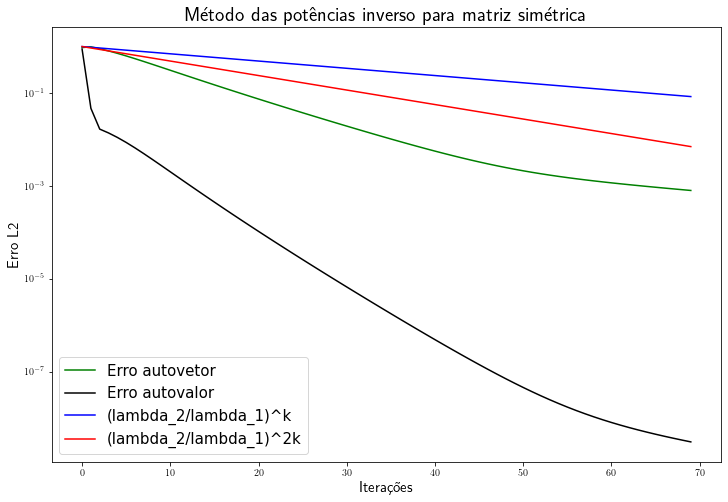

In [5]:
M1 = MetodoDasPotenciasInverso(A1, 1.1, 70, 1e-15)
M1.calcula_aproximacao()
M1.gera_grafico_comparativo("Método das potências inverso para matriz simétrica")

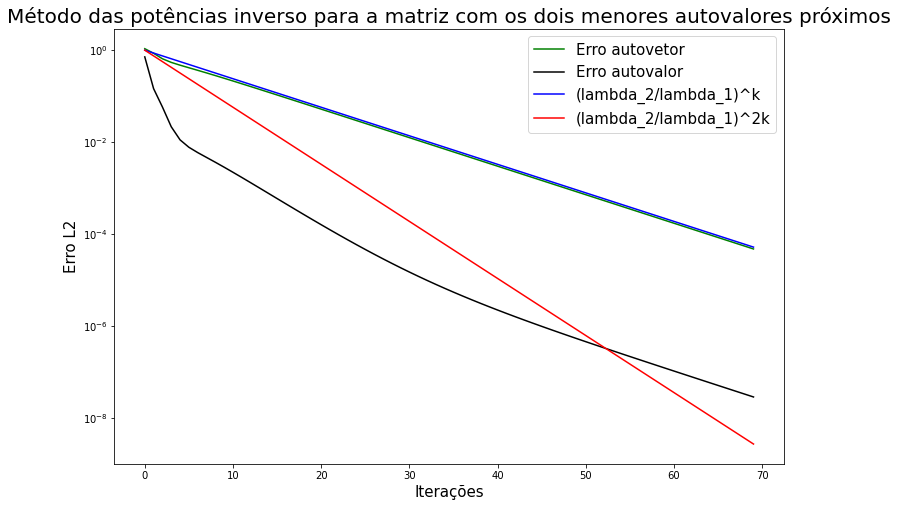

In [6]:
M21 = MetodoDasPotenciasInverso(A21, 1.1, 70, 1e-15)
M21.calcula_aproximacao()
M21.gera_grafico_comparativo("Método das potências inverso para a matriz com os dois menores autovalores próximos")

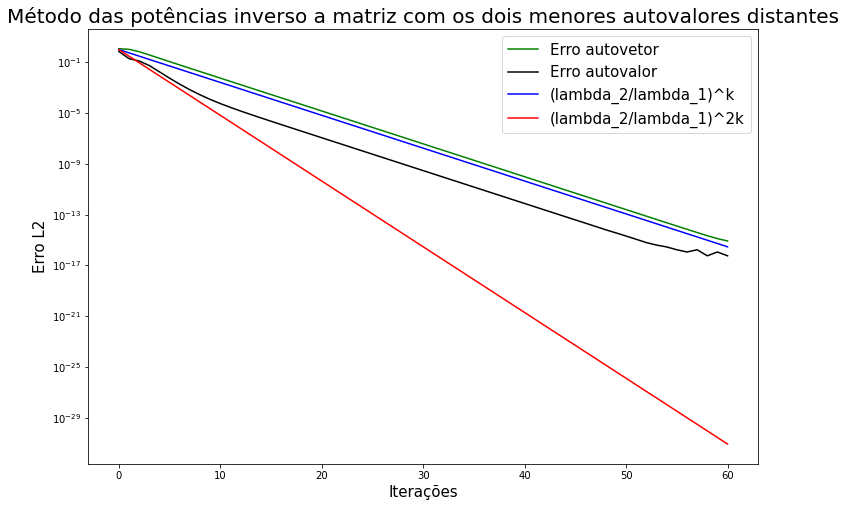

In [7]:
M22 = MetodoDasPotenciasInverso(A22, 1.1, 70, 1e-15)
M22.calcula_aproximacao()
M22.gera_grafico_comparativo("Método das potências inverso a matriz com os dois menores autovalores distantes")